# UCB

In [1]:
import jax
from jax import random
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial

In [2]:
import pandas as pd

In [3]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

## The 10-armed Testbed

In [4]:
key = random.PRNGKey(31415)

key_bandit, key_sample = random.split(key, 2)
n_bandits = 10
true_values = random.normal(key_bandit, (n_bandits,))
true_values

DeviceArray([ 0.09987473, -0.21256812,  1.452159  , -0.8110446 ,
             -0.8929844 ,  0.612494  , -1.8329986 ,  0.21462004,
             -0.821045  ,  0.38306305], dtype=float32)

In [5]:
n_samples = 5000
bandit_samples = random.normal(key_sample, (n_bandits, n_samples)) + true_values[:, None]
bandit_samples.shape

(10, 5000)

In [6]:
bandit_samples = pd.DataFrame(bandit_samples.T).melt()
bandit_samples = bandit_samples.rename({"variable":"action", "value":"reward"}, axis=1)

(-4.0, 4.0)

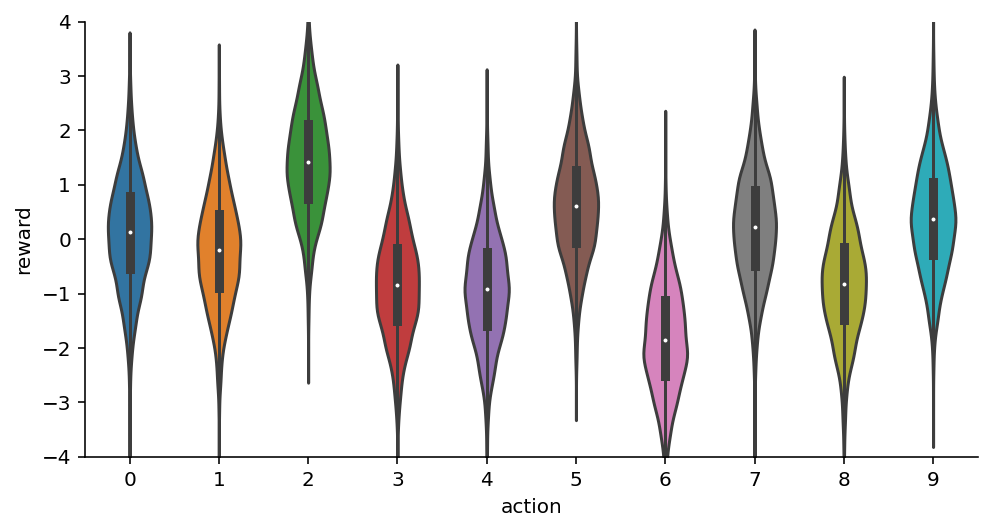

In [7]:
plt.subplots(figsize=(8, 4))
sns.violinplot(x="action", y="reward", data=bandit_samples, width=0.5)
plt.ylim(-4, 4)

## UCB method

$$
    Q_t(a) := \frac{\sum_{\tau=1}^{t-1} R_\tau \mathbb{1}(A_{\tau=a})}{\sum_{\tau=1}^{t-1} \mathbb{1}(A_{\tau=a})}\\
$$

$$
    A_t := \text{argmax}_a\,\left[ Q_t(a) + c\,\sqrt{\frac{\ln t}{N_t(a)}} \right]
$$

In [11]:
num_steps = 1000
c = 2
bandits = jnp.arange(n_bandits)
key_step = random.PRNGKey(3141)

In [14]:
def take_UCB(state, key, c):
    num_visits, cumulative_rewards = state
    key_action_UCB, key_reward = random.split(key, 2)
    
    Qt = cumulative_rewards / jnp.maximum(num_visits, 1)
    t = jnp.sum(num_visits) + 1
    Nt = jnp.maximum(num_visits, 1)
    UCBt = Qt + c*jnp.sqrt( jnp.log(t)/Nt )
    
    map_choice = UCBt.max() == UCBt
    prob_choice_UCB = map_choice / map_choice.sum()
    
    action = random.choice(key_action_UCB, bandits, p=prob_choice_UCB)
   
    reward = random.normal(key_reward) + true_values[action.astype(int)]
    
    action_ohe = jax.nn.one_hot(action, n_bandits)
    num_visits = num_visits + action_ohe
    cumulative_rewards = cumulative_rewards + action_ohe * reward
    
    return (num_visits, cumulative_rewards), (reward, action)


def UCB_learn(key, c, num_steps, init_rewards):
    keys = random.split(key, num_steps)
    take_UCB_c = partial(take_UCB, c=c)
    num_visits = jnp.zeros_like(init_rewards)
    
    init_state = (num_visits, init_rewards)
    (num_visits, cumulative_rewards), (reward_hist, action_hist) = jax.lax.scan(take_UCB_c, init_state, keys)
    return (num_visits, cumulative_rewards), (reward_hist, action_hist)


# Note: 
# 1. vmap (0, 0, None, None) is not the same as 'vmapping'
# 2. first over (0, None, None, None) and then over (None, 0, None, None).
# The behaviour of 1. is one-to-one, the behaviour of 2. is cross-product

# vmap over keys for multiple samples
UCB_learn = jax.vmap(UCB_learn, (0, None, None, None))
# vmap over c for multiple configurations
UCB_learn = jax.vmap(UCB_learn, (None, 0, None, None))

## UCB

In [19]:
nsims = 2000
num_steps = 1000
init_rewards = jnp.zeros(n_bandits)

key = random.PRNGKey(314)
keys = random.split(key, nsims)
c_values = jnp.array([0.5, 1., 2., 3.])

_, (reward_sims_multiple, action_sims_multiple) = UCB_learn(keys, c_values, num_steps, init_rewards)

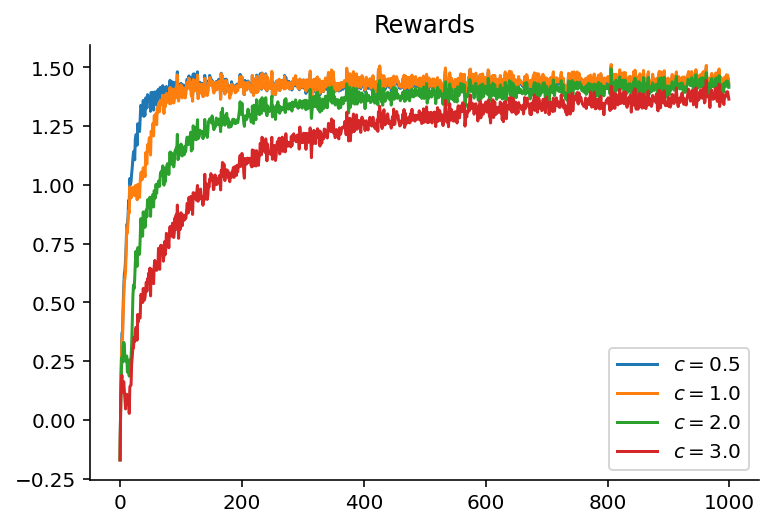

In [20]:
plt.plot(reward_sims_multiple.mean(axis=1).T)
legends = ["$c=$"f"{c:0.1f}" for c in c_values]
plt.title("Rewards")
plt.legend(legends);

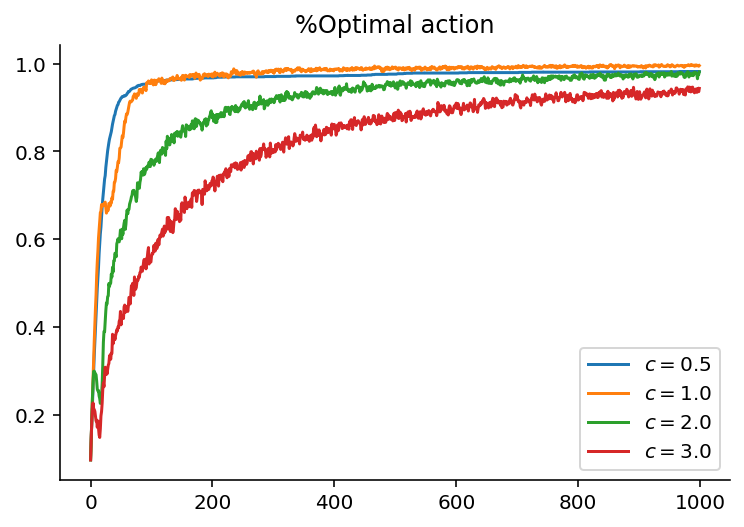

In [23]:
plt.title("%Optimal action")
plt.plot((action_sims_multiple == true_values.argmax()).mean(axis=1).T)
legends = ["$c=$"f"{c:0.1f}" for c in c_values]
plt.legend(legends);